<a href="https://colab.research.google.com/github/selintyrs/RAG-and-embeddings-KIA/blob/main/rag_and_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a FAISS-Based Vector Store: A Journey Through Data Processing and Visualization

In this notebook, you'll learn how to transform raw PDF documents into a searchable vector store using FAISS. We'll go on a journey where we:

1. **Read and extract text from PDF files.**
2. **Split the text into manageable chunks.**
3. **Display tokenization outputs from different tokenizers.**
4. **Generate embeddings from the text using a SentenceTransformer.**
5. **Store the embeddings in a FAISS index.**
6. **Project the embeddings into 2D space using UMAP for visualization.**
7. **Visualize the entire process on a scatter plot.**
8. **Incect your data into a prompt for a large language model**

In [ ]:
!pip install langchain langchain-community faiss-cpu sentence-transformers pypdf python-dotenv groq


In [ ]:
import os
import tqdm
import glob
from pypdf import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings  # For generating embeddings for text chunks
import faiss
import pickle
import matplotlib.pyplot as plt
import umap.umap_ as umap
import numpy as np
from dotenv import load_dotenv
from groq import Groq


## 1. Reading Data from PDFs

First, we load PDF files from a directory, extract their text content, and combine it into one large text string.

In [ ]:
### load the pdf from the path
glob_path = "data/*.pdf"
text = ""
for pdf_path in tqdm.tqdm(glob.glob(glob_path)):
    with open(pdf_path, "rb") as file:
        print(file)
        reader = PdfReader(file)
         # Extract text from all pages in the PDF
        text += " ".join(page.extract_text() for page in reader.pages if page.extract_text())

text[:50]

  0%|          | 0/9 [00:00<?, ?it/s]

<_io.BufferedReader name='data/Z_RL_Richtlinie_KI_bei_Leistungsnachweisen.pdf'>


 11%|█         | 1/9 [00:00<00:03,  2.58it/s]

<_io.BufferedReader name='data/Z_MB_Merkblatt_Verwendung_von_generativer_KI_in_Arbeiten.pdf'>


 22%|██▏       | 2/9 [00:01<00:05,  1.36it/s]

<_io.BufferedReader name='data/Bibliotheksangebot_Bachelorarbeit_HS24FS25.pdf'>
<_io.BufferedReader name='data/W_MB_Merkblatt_Bachelorarbeit_BSc.pdf'>


 44%|████▍     | 4/9 [00:02<00:02,  1.98it/s]

<_io.BufferedReader name='data/05_Checkliste_Sprachliche_Formale_Ausarbeitung.pdf'>
<_io.BufferedReader name='data/Schwerpunktthemen_fuer_Studenten.pdf'>


 78%|███████▊  | 7/9 [00:02<00:00,  3.37it/s]

<_io.BufferedReader name='data/02_Merkblatt_Vermeidung-von-Plagiaten_0916.pdf'>
<_io.BufferedReader name='data/ZHAW_Zitierleitfaden_DE.pdf'>


 89%|████████▉ | 8/9 [00:03<00:00,  1.79it/s]

<_io.BufferedReader name='data/Z_RL_Richtlinie_Anhang_Deklarationspflicht_KI_bei_Arbeiten.pdf'>


100%|██████████| 9/9 [00:04<00:00,  2.11it/s]


'Z-RL-Richtlinie  KI bei Leistungsnachweisen  \nVers'

## 2. Splitting the Text into Chunks

Large texts can be difficult to work with. We use a text splitter, in this case [RecursiveCharacterTextSplitter](https://python.langchain.com/docs/how_to/recursive_text_splitter/),  to break the full text into smaller, overlapping chunks. This helps preserve context when we later embed the text.

In [ ]:
# Create a splitter: 2000 characters per chunk with an overlap of 200 characters
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
# Split the extracted text into manageable chunks
chunks = splitter.split_text(text)

In [ ]:
print(f"Total chunks: {len(chunks)}")
print("Preview of the first chunk:", chunks[0][:200])

Total chunks: 61
Preview of the first chunk: Z-RL-Richtlinie  KI bei Leistungsnachweisen  
Version:  3.0.0 gültig ab:  01.03.2025   Seite 1 von 4 
 
Rektorat 
Ressort Bildung 
Verwendung generativer KI-Systeme bei Leistungsnachweisen 
1. Grundla


## 3. Tokenizing the Text with Different Tokenizers

Before embedding, it's insightful to see how different tokenizers break up our text. Here, we use the tokenizer from the SentenceTransformer model (see [SentenceTransformersTokenTextSplitter](https://python.langchain.com/api_reference/text_splitters/sentence_transformers/langchain_text_splitters.sentence_transformers.SentenceTransformersTokenTextSplitter.html#sentencetransformerstokentextsplitter)).

In [ ]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=128, model_name="paraphrase-multilingual-MiniLM-L12-v2")

In [ ]:
token_split_texts = []
for text in chunks:
    token_split_texts += token_splitter.split_text(text)

print(f"\nTotal chunks: {len(token_split_texts)}")
print(token_split_texts[0])


Total chunks: 246
Z-RL-Richtlinie KI bei Leistungsnachweisen Version: 3.0.0 gültig ab: 01.03.2025 Seite 1 von 4 Rektorat Ressort Bildung Verwendung generativer KI-Systeme bei Leistungsnachweisen 1. Grundlagen − Rahmenprüfungsordnung für Bachelor- und Masterstudiengänge − Rahmenstudienordnung für Weiterbildungs-Masterstudiengänge − Rahmenstudienordnung für Diplom- und Zertifikatslehrgänge an der ZHAW − Reglement Digitale Prüfungen − Reglement zur Nutzung der ZHAW IT-Infrastruktur − Merkblatt zur Vermeidung von Plagiaten − Checkliste Un


In [ ]:
model_name = "paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['<s>', '▁Z', '-', 'RL', '-', 'Richtlinie', '▁KI', '▁bei', '▁Leistungs', 'nach', 'weise', 'n', '▁Version', ':', '▁3.', '0.0', '▁gültig', '▁ab', ':', '▁01.', '03.20', '25', '▁Seite', '▁1', '▁von', '▁4', '▁Rektor', 'at', '▁Res', 'sort', '▁Bildung', '▁Verwendung', '▁genera', 'ti', 'ver', '▁KI', '-', 'System', 'e', '▁bei', '▁Leistungs', 'nach', 'weise', 'n', '▁1.', '▁Grundlage', 'n', '▁−', '▁Rahmen', 'prüfung', 's', 'ordnung', '▁für', '▁Bachelor', '-', '▁und', '▁Master', 'studie', 'n', 'gänge', '▁−', '▁Rahmen', 'studie', 'n', 'ordnung', '▁für', '▁Weiterbildung', 's', '-', 'Master', 'studie', 'n', 'gänge', '▁−', '▁Rahmen', 'studie', 'n', 'ordnung', '▁für', '▁Diplom', '-', '▁und', '▁Zer', 'tifik', 'ats', 'le', 'hr', 'gänge', '▁an', '▁der', '▁Z', 'HA', 'W', '▁−', '▁Reg', 'lement', '▁Digital', 'e', '▁Prüfung', 'en', '▁−', '▁Reg', 'lement', '▁zur', '▁Nutzung', '▁der', '▁Z', 'HA', 'W', '▁IT', '-', 'In', 'fra', 'struktur', '▁−', '▁Merk', 'blatt', '▁zur', '▁Verme', 'i', 'dung', '▁von', '▁

In [ ]:
model_name = "Sahajtomar/German-semantic"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['[CLS]', 'Z', '-', 'R', '##L', '-', 'Richtlinie', 'K', '##I', 'bei', 'Leistungs', '##nach', '##weisen', 'Version', ':', '3', '.', '0', '.', '0', 'gültig', 'ab', ':', '01', '.', '03', '.', '202', '##5', 'Seite', '1', 'von', '4', 'Rektor', '##at', 'Ressort', 'Bildung', 'Verwendung', 'gener', '##ativer', 'K', '##I', '-', 'Systeme', 'bei', 'Leistungs', '##nach', '##weisen', '1', '.', 'Grundlagen', '−', 'Rahmen', '##prüfung', '##sor', '##dn', '##ung', 'für', 'Bachelor', '-', 'und', 'Masters', '##tu', '##dien', '##gänge', '−', 'Rahmen', '##studien', '##ordnung', 'für', 'Weiterbildungs', '-', 'Masters', '##tu', '##dien', '##gänge', '−', 'Rahmen', '##studien', '##ordnung', 'für', 'Diplom', '-', 'und', 'Zertif', '##ikat', '##sl', '##ehr', '##gänge', 'an', 'der', 'Z', '##H', '##AW', '−', 'Reg', '##le', '##ment', 'Digital', '##e', 'Prüfungen', '−', 'Reg', '##le', '##ment', 'zur', 'Nutzung', 'der', 'Z', '##H', '##AW', 'IT', '-', 'Infrastruktur', '−', 'Merk', '##blatt', 'zur', 'Vermeidung

## 4. Generating Embeddings for Each Chunk

Now we convert each text chunk into a numerical embedding that captures its semantic meaning. These embeddings will be used for similarity search.

In [ ]:
embeddings = HuggingFaceEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2")
chunk_embeddings = model.encode(token_split_texts, convert_to_numpy=True)

## 5. Building a FAISS Vector Store

FAISS is a powerful library for efficient similarity search. Here, we build an index from our embeddings. Remember, FAISS only stores the numerical vectors so we must keep our original text mapping separately.

In [ ]:
d = chunk_embeddings.shape[1]
print(d)

1024


In [ ]:
index = faiss.IndexFlatL2(d)
index.add(chunk_embeddings)
print("Number of embeddings in FAISS index:", index.ntotal)

Number of embeddings in FAISS index: 246


In [ ]:
if not os.path.exists('faiss'):
    os.makedirs('faiss')

faiss.write_index(index, "faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "wb") as f:
    pickle.dump(chunks, f)

In [ ]:
index_2 = faiss.read_index("faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "rb") as f:
    token_split_texts_2 = pickle.load(f)
print(len(token_split_texts_2))
print(len(token_split_texts))

61
246


## 6. Projecting Embeddings with UMAP

To visualize high-dimensional embeddings, we use UMAP to project them into 2D space. You can project both the entire dataset and individual query embeddings.

In [ ]:
# Fit UMAP on the full dataset embeddings
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(chunk_embeddings)

def project_embeddings(embeddings, umap_transform):
    """
    Project a set of embeddings using a pre-fitted UMAP transform.
    """
    umap_embeddings = np.empty((len(embeddings), 2))
    for i, embedding in enumerate(tqdm.tqdm(embeddings, desc="Projecting Embeddings")):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
# Project the entire dataset embeddings
projected_dataset_embeddings = project_embeddings(chunk_embeddings, umap_transform)
print("Projected dataset embeddings shape:", projected_dataset_embeddings.shape)

Projecting Embeddings:   0%|          | 0/246 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will

Projected dataset embeddings shape: (246, 2)


## 7. Querying the Vector Store and Projecting Results

We now define a retrieval function that takes a text query, embeds it, and searches our FAISS index for similar documents. We then project these result embeddings with UMAP.
"""

In [ ]:
def retrieve(query, k=5):
    """
    Retrieve the top k similar text chunks and their embeddings for a given query.
    """
    query_embedding = model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, k)
    retrieved_texts = [token_split_texts[i] for i in indices[0]]
    retrieved_embeddings = np.array([chunk_embeddings[i] for i in indices[0]])
    return retrieved_texts, retrieved_embeddings, distances[0]

In [ ]:
query = "KI während der Bachelorarbeit"
results, result_embeddings, distances = retrieve(query, k=3)
print("Retrieved document preview:")
print(results[0][:300])

Retrieved document preview:
e Studium Publikationsart Public [...] Schliesslich sei erwähnt, dass generative KI-Systeme bzw. KI-Tools einerseits als Inspirationsquelle und für ein initiales Brainstorming verwendet wurden. Besonders die kritische dialogische Auseinandersetzung mit [...] und seinen Inhalten hat meine Arbeit und 


In [ ]:
# Project the result embeddings
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

# Also embed and project the original query for visualization
query_embedding = model.encode([query], convert_to_numpy=True)
project_original_query = project_embeddings(query_embedding, umap_transform)

Projecting Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings: 100%|██████████| 1/1 [00:00<00:00, 107.71it/s]


## 8. Visualizing the Results

Finally, we create a scatter plot to visualize the entire dataset, the retrieved results, and the original query in 2D space.

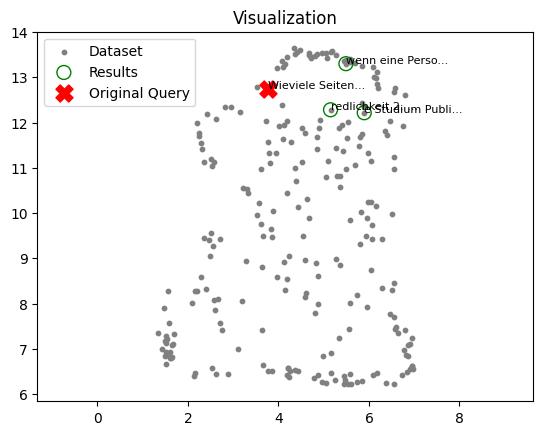

In [ ]:

def shorten_text(text, max_length=15):
    """Shortens text to max_length and adds an ellipsis if shortened."""
    return (text[:max_length] + '...') if len(text) > max_length else text

plt.figure()

# Scatter plots
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1],
            s=10, color='gray', label='Dataset')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1],
            s=100, facecolors='none', edgecolors='g', label='Results')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1],
            s=150, marker='X', color='r', label='Original Query')

# If results is a list of texts, iterate directly
for i, text in enumerate(results):
    if i < len(projected_result_embeddings):
        plt.annotate(shorten_text(text),
                     (projected_result_embeddings[i, 0], projected_result_embeddings[i, 1]),
                     fontsize=8)

# Annotate the original query point
original_query_text = 'Welche hilfsmittel sind erlaubt?'  # Replace with your actual query text if needed
original_query_text = 'Wieviele Seiten muss die Arbeit sein?'  # Replace with your actual query text if needed

plt.annotate(shorten_text(original_query_text),
             (project_original_query[0, 0], project_original_query[0, 1]),
             fontsize=8)

plt.gca().set_aspect('equal', 'datalim')
plt.title('Visualization')
plt.legend()
plt.show()


---

# 📝 Task: Semantic Retrieval-Augmented Question Answering Using Groq LLM

## Objective
Implement a question-answering system that:
1. Retrieves the most semantically relevant text passages to a user query.
2. Constructs a natural language prompt based on the retrieved content.
3. Uses a large language model (LLM) hosted by Groq to generate an answer.

---

## Task Breakdown

### 1. Embedding-Based Semantic Retrieval
- Use the `SentenceTransformer` model `"Sahajtomar/German-semantic"` to encode a user query into a dense vector embedding.
- Perform a nearest-neighbor search in a prebuilt FAISS index to retrieve the top-**k** similar text chunks. You can **use the prebuilt FAISS form above**.


### 2. LLM Prompt Construction and Query Answering
- Build the prompt:
  - Using the retrieved text chunks, concatenates the results into a context block.
  - Builds a **prompt** asking the LLM to answer the question using that context.
  - Sends the prompt to the **Groq LLM API** (`llama-3.3-70b-versatile`) and returns the response.

### 3. User Query Execution
- An example query (`"What is the most important factor in diagnosing asthma?"`) is used to demonstrate the pipeline.
- The final answer from the LLM is printed.


## Tools & Models Used
- **SentenceTransformers** (`Sahajtomar/German-semantic`) for embedding generation.
- **FAISS** for efficient vector similarity search.
- **Groq LLM API** (`llama-3.3-70b-versatile`) for generating the final response.


## 1. Embedding-Based Semantic Retrieval

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

# 1. Lade das spezialisierte deutsche Modell
model = SentenceTransformer("Sahajtomar/German-semantic")

# 2. Benutzerfrage eingeben
query = "Wie funktioniert semantische Vektorsuche?"

# 3. Frage in Embedding umwandeln
query_embedding = model.encode(query)

# 4. Ähnlichste Chunks im FAISS-Index finden
k = 3  # Anzahl der Top-Treffer
D, I = index.search(np.array([query_embedding]), k)

# 5. Ausgabe der Ergebnisse
print(f"🔍 Top {k} ähnliche Textpassagen zur Frage:\n")
for idx in I[0]:
    print(f"🔹 Chunk {idx}:\n{token_split_texts[idx][:500]}...\n{'-'*60}")


🔍 Top 3 ähnliche Textpassagen zur Frage:

🔹 Chunk 235:
in meiner Arbeit. Andererseits wur- den KI-Tools u.a. für das Recherchieren von Literatur, das Strukturieren der Arbeit in Unterkapitel, das Zusammenfassen von Literatur, das Verstehen von Inhalten, das Formulieren von Texten, oder die Bildgenerierung verwendet. Es kann hierfür auf das spezifische Verzeichnis verwiesen werden....
------------------------------------------------------------
🔹 Chunk 236:
Formulieren von Texten, oder die Bildgenerierung verwendet. Es kann hierfür auf das spezifische Verzeichnis verwiesen werden. − Beispiel 2 (detaillierend bei fehlendem spezifischem Verzeichnis bzw. bei fehlender Möglichkeit, den Verwendungszweck von generativen KI Systemen in Anwendung von Literaturverwaltungsprogrammen im allgemeinen Literaturverzeichnis selbst abzubil- den): Einleitung [...] Schliesslich sei erwähnt, dass generative KI-Systeme bzw. KI-Tools einerseits als In- spirationsquelle ...
-----------------------------------

## 2. LLM Prompt Construction and Query Answering


In [ ]:
load_dotenv()
# Access the API key using the variable name defined in the .env file
groq_api_key = os.getenv("GROQ_API_KEY")

In [ ]:
# 1. Groq Client initialisieren (Key muss per .env geladen sein)
client = Groq()

# 2. Kontext aufbauen – ACHTUNG: token_split_texts statt chunks!
retrieved_chunks = [token_split_texts[idx] for idx in I[0]]
context = "\n---\n".join(retrieved_chunks)

# 3. Prompt erstellen
prompt = f"""Beantworte die folgende Frage basierend auf dem gegebenen Kontext.

Kontext:
{context}

Frage:
{query}

Antwort:"""

# 4. Anfrage an Groq stellen
response = client.chat.completions.create(
    model="llama-3.3-70b-versatile",
    messages=[
        {"role": "user", "content": prompt}
    ]
)

# 5. Ausgabe
print("🤖 Groq LLM Antwort:\n")
print(response.choices[0].message.content.strip())


🤖 Groq LLM Antwort:

Die Frage "Wie funktioniert semantische Vektorsuche?" wird nicht direkt im Kontext beantwortet. Der Kontext behandelt hauptsächlich die Verwendung von KI-Tools in der Arbeit, wie zum Beispiel die Verwendung von KI-Tools für das Recherchieren von Literatur, das Strukturieren der Arbeit, das Zusammenfassen von Literatur, das Verstehen von Inhalten, das Formulieren von Texten oder die Bildgenerierung.

Semantische Vektorsuche ist jedoch ein Konzept, das oft in KI-Systemen und Literaturverwaltungsprogrammen verwendet wird. Im Allgemeinen funktioniert semantische Vektorsuche wie folgt:

Bei der semantischen Vektorsuche werden Texte oder Dokumente in Vektoren umgewandelt, die ihre semantischen Bedeutungen repräsentieren. Diese Vektoren werden dann in einem hochdimensionalen Raum dargestellt, in dem ähnliche Konzepte und Bedeutungen nahe beieinander liegen.

Wenn eine Suche durchgeführt wird, wird die Suchanfrage ebenfalls in einen Vektor umgewandelt und dann mit den Vekt

## 3. User Query Execution

In [ ]:
# 1. Neue Benutzerfrage eingeben
query = "Was ist der wichtigste Faktor bei der Diagnose von Asthma?"

# 2. Frage in Embedding umwandeln
query_embedding = model.encode(query)

# 3. Ähnlichste Chunks im FAISS-Index finden
k = 3
D, I = index.search(np.array([query_embedding]), k)

# 4. Kontext aus den Top-k Textstücken bauen (aus token_split_texts!)
retrieved_chunks = [token_split_texts[idx] for idx in I[0]]
context = "\n---\n".join(retrieved_chunks)

# 5. Prompt bauen
prompt = f"""Beantworte die folgende Frage basierend auf dem gegebenen Kontext.

Kontext:
{context}

Frage:
{query}

Antwort:"""

# 6. Anfrage an Groq-LLM senden
response = client.chat.completions.create(
    model="llama-3.3-70b-versatile",
    messages=[
        {"role": "user", "content": prompt}
    ]
)

# 7. Antwort ausgeben
print("🤖 Groq LLM Antwort:\n")
print(response.choices[0].message.content.strip())


🤖 Groq LLM Antwort:

Die Frage nach dem wichtigsten Faktor bei der Diagnose von Asthma ist nicht direkt mit dem bereitgestellten Kontext verbunden. Der Kontext behandelt die Anwendung von Sprachtechnologien und KI-Tools in der wissenschaftlichen Arbeit, insbesondere in Bezug auf die kritische Auseinandersetzung mit Inhalten und die Erkennung von Grenzen und möglichen Verzerrungen in erzeugten Inhalten.

Um auf die Frage nach dem wichtigsten Faktor bei der Diagnose von Asthma zu antworten, müssten wir uns auf medizinische Erkenntnisse und Diagnosekriterien für Asthma beziehen. Einige der wichtigsten Faktoren bei der Diagnose von Asthma können umfassen:

1. **Symptome**: Die Anwesenheit typischer Symptome wie Atemnot, Husten, especially nachts oder bei körperlicher Anstrengung, und Wheezing (Pfeifen oder Gurgeln in der Lunge).
2. **Medizinische Geschichte**: Eine Vorgeschichte von Allergien, vorherigen Atemwegserkrankungen oder einer familiären Neigung zu Asthma.
3. **Lungenfunktionstest